In [602]:
import pandas as pd
import numpy as np
import json
import time
import re
import matplotlib.pyplot as plt

from datetime import datetime

filename = 'reports/report_P1.json'

In [603]:
with open(filename, encoding="utf-8") as f:
    target = f.read()

In [604]:
data['2']['data'].keys()

dict_keys(['title', 'content', 'date', 'flag', 'marks', 'mouse', 'key'])

In [608]:
data = json.loads(target)
note_number = '2'

data[note_number]['data']['title']
data[note_number]['data']['content']
# start time
tstamp = data[note_number]['data']['key'][0]['timestamp']
print("Start Time: {}".format(datetime.fromtimestamp((tstamp)/1000.0)))

Start Time: 1969-12-31 16:07:57.403200


## Writing Length (Words Count)

In [609]:
content = data[note_number]['data']['content'].strip()
print(f"Note length: {len(content)} characters")
print(f"Note length: {len(content.split(' '))} words")

Note length: 2016 characters
Note length: 375 words


## Writing Content

In [610]:
# text
print("Full note:")
print(content)
words_in_note = re.sub(r'[^\w\s]', '', content).lower().split(' ')

Full note:
It is July 6th, I still feel that June has not ended. I guess it is because my days have been packed by tight schedule and heavy labor work so that every day seems a little bit longer than it should be. But all in all, the most difficult times have passed (maybe!) and a brand new summer is waiting for me!

Summer does not mean vacation. For PhD students in HCI, summer is just another name of 'work all day for your CHI submission'. I have no problem with it as long as I love my project. However, I felt anxious for not being paid :( Yes I will receive no payments throughout the long summer, while I still need to pay housing, utilities and groceries! The insufficient income has affected my passion for work. I cannot stop thinking about money whenever I feel tired of debugging, or staying up late for ideation. It influenced both my mood and efficiency negatively. But I use the past tense. I have already overcome the obstacle.

I wanna conclude takeaways so I will also recover qu

In [611]:
import os
from pathlib import Path

pkl_file = Path(os.getcwd())# + '/../dict/picked-dict.pkl')
pkl_file = pkl_file.parents[0] / 'dict' / 'pickled-dict-full.pkl'
print(pkl_file)

unpickle_dict = pd.read_pickle(pkl_file)
expanded = unpickle_dict.explode('wordnet_ext').reset_index(drop=True)
expanded = expanded.explode('phrase_ext').reset_index(drop=True)

/Users/royjara/dev/hci_lab/journal/dict/pickled-dict-full.pkl


In [612]:
expanded['Word'] = expanded['Word'].str.strip()
expanded['wordnet_ext'] = expanded['wordnet_ext'].str.strip()
expanded['phrase_ext'] = expanded['phrase_ext'].str.strip()

In [613]:
target_words = pd.unique(expanded['Word'].dropna().apply(lambda x: x.strip()))
target_words = np.append(target_words, pd.unique(expanded['wordnet_ext'].dropna().apply(lambda x: x.strip())))
target_words = np.append(target_words, pd.unique(expanded['phrase_ext'].dropna().apply(lambda x: x.strip())))

In [614]:
def get_ngram(alist, n):# {
    holder = []
    for i in range(len(alist) - (n-1)): 
        temp = alist[i]
        for j in range(1,n):
            temp = temp+ " " + alist[i + j]
        holder.append(temp)
    return holder

In [615]:
words_to_analyze = words_in_note + get_ngram(words_in_note, 2)
words_to_analyze = words_to_analyze+get_ngram(words_in_note, 3)

In [616]:
filtered_content = [x for x in words_to_analyze if x in target_words]

In [617]:
cat_dict = {}

for word in filtered_content:
    # find category it belongs to
    res = expanded[expanded['Word'].str.fullmatch(word, na=False) ]
    cat = ''
    if len(res) > 0:
        cat = res['Strategy No.'].values[0]
        # print(cat)
    else:
        res = expanded[expanded['wordnet_ext'].str.fullmatch(word, na=False) ]
        if len(res) > 0:
            cat = res['Strategy No.'].values[0]
            # print(cat)
        else:
            res = expanded[expanded['phrase_ext'].str.fullmatch(word, na=False) ]
            if len(res) > 0:
                cat = res['Strategy No.'].values[0]
                # print(cat)
            else: 
                pass
                # print('not found')
            
    # print('*********************************')
    
    if cat in cat_dict.keys():
        cat_dict[cat]+=1
    else:
        cat_dict[cat] = 1

cat_dict = dict(sorted(cat_dict.items()))

print(f"results: {cat_dict}")

results: {'L2a': 4, 'L2b': 9, 'L2e': 9, 'L2f': 5}


([<matplotlib.axis.XTick at 0x7f856d6f1a90>,
 [Text(0, 0, 'L2a'), Text(1, 0, 'L2b'), Text(2, 0, 'L2e'), Text(3, 0, 'L2f')])

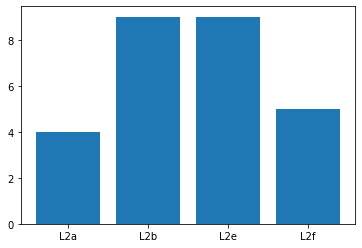

In [618]:
plt.bar(range(len(cat_dict)), list(cat_dict.values()), align='center')
plt.xticks(range(len(cat_dict)), list(cat_dict.keys()))

## Writing Behavior

JS EVT TIMESTAMP ==> TIME IN MILLISECONDS!


Analysis approach:
- no need to know actual time, just the difference between events
- plot the timestamps in the same order as indices.
- then bundle up all the rising ones as one session
- then analyze per session and combine!

<AxesSubplot:>

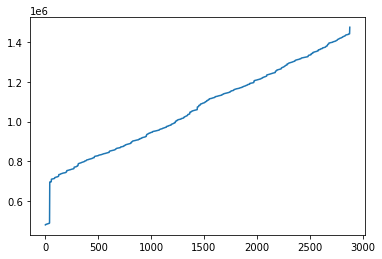

In [619]:
df = pd.DataFrame(data[note_number]['data']['key'])
df = df.drop([0])
df["timestamp"].plot()

In [620]:
df['timestamp_diff'] = df['timestamp'].diff()
df['session_id'] = df.apply(lambda row: 1 if row['timestamp_diff'] < 0 else 0, axis=1).cumsum()
df['pauses'] = df.apply(lambda row: 1 if row['timestamp_diff'] > 3000 else 0, axis=1)
df[['text', 'cursor', 'timestamp', 'session_id', 'timestamp_diff', 'pauses']][df['pauses']==1].head(3)

,text,cursor,timestamp,session_id,timestamp_diff,pauses
41,,"{'line': 0, 'ch': 0, 'sticky': None}",694293.7,0,207306.0,1
57,,"{'line': 0, 'ch': 0, 'sticky': None}",708574.9,0,12840.8,1
88,,"{'line': 0, 'ch': 0, 'sticky': None}",715575.7,0,3160.4,1


In [621]:
pause_list = df.index[df['pauses'] == 1].tolist()

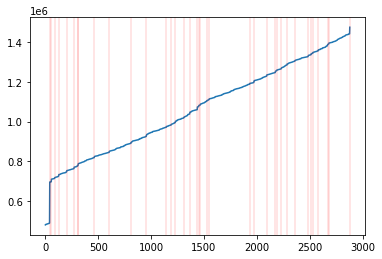

In [622]:
df["timestamp"].plot()
[plt.axvline(_x, linewidth=0.2, color='r') for _x in pause_list]
# missing ax labels (x-keystroke event, y-timestamp) 
# larger size
# red overlay lines represent pauses
# big drop is the resetting of the session --> could be adjusted to make continuous. 
# idk if there is any value in displaying the sessions

In [623]:
# writing duration -- aggregate per session_id and add results
a = df.groupby('session_id')['timestamp'].max()
print(f"Writing duration {(a.sum()/1000)/60:.2f} minutes")

Writing duration 24.62 minutes


In [624]:
# save to csv for further inspection.
df[['text', 'cursor', 'timestamp', 'session_id', 'timestamp_diff', 'pauses']][df['pauses']==1].to_csv('pauses.csv')

## Interactions with features

Simplify!
- separate into groups of interactions (columns): dismisses, accepts, l2dismisses
- but at the same time (before or after) 
- find unique for both 

- Marks can be either placeholder (L1/L3) or highlights (L2)
- dismisses are the L1/L3 dismisses
- accepts are the L1/L3 accepts
- l2dismisses are the 
- placeholder only relevant if marks has placeholder

In [625]:
df_mouse = pd.DataFrame(data[note_number]['data']['mouse']).drop(0)
df_key = pd.DataFrame(data[note_number]['data']['key']).drop(0)

## df_mouse['marks']
By keeping the unique values, we can show all the different highlights in full

In [636]:
# shows total number of different highlights
df_mouse_marks = df_mouse[df_mouse['marks'].map(lambda d: len(d)) > 0] \
                                           .drop(['placeholder','dismisses','accepts','l2dismisses','x','y'], axis=1) \
                                           .astype(str) \
                                           .drop_duplicates(subset=['marks'])
df_mouse_marks

,timestamp,type,marks
19,1476048.7000000477,click,"[{'tag': 'CodeMirror-selectedtext', 'from': {'..."


## df_key['marks']
Useful if you want to see the progression of typing with placeholders.

In [637]:
# shows keystroke updates when filling in placeholder text
df_key_marks = df_key[df_key['marks'].notnull()] \
                                     .drop(['keycode','dismisses','cursor', 'placeholder', 'accepts', 'l2dismisses'], axis=1) \
                                     .astype(str) \
                                     .drop_duplicates(subset=['marks'])
                      
df_key_marks #.to_csv('dummy.csv')

,timestamp,type,text,marks
1,477563.2999999523,type,,[]
2878,1477002.2000000477,type,"It is July 6th, I still feel that June has not...","[{'tag': 'CodeMirror-selectedtext', 'from': {'..."


In [633]:
df_key_marks_f = pd.DataFrame(df_key.loc[df_key_marks.index].explode('marks')['marks'].dropna().to_list())#.drop_duplicates(subset=['suggestion'])
df_key_marks_f[df_key_marks_f['tag']=='placeholder']#.astype(str).drop_duplicates(subset=['from','to'])
# df_key_marks_f[df_key_marks_f['tag']=='L2-highlight'].astype(str).drop_duplicates(subset=['from','to'])

,tag,from,to


## df_key['dismisses']
at end, shows if backspaced or how far along the user typed
- Problem1: don't know if it is L1 or L3 --> SOLUTION lookup in dict df
- Problem2: timestamp is in unix datetime structure (fixed in latest push to repo)


In [550]:
df_key_dis = df_key[df_key['dismisses'].notnull()] \
                                     .drop(['keycode','cursor', 'marks','accepts', 'l2dismisses'], axis=1) \
                                     .astype(str) \
                                     .drop_duplicates(subset=['dismisses'])
                      
dis_idx = df_key_dis.index

In [551]:
pd.DataFrame(df_key.loc[dis_idx].explode('dismisses')['dismisses'].to_list()).drop_duplicates(subset=['suggestion'])

,time,suggestion,completed_amount
0,1657165258648,"When I say this, I mean...",-1
1,1657165308161,"To be specific,",-1
2,1657165317258,A different point of view can be...,-1
3,1657165345840,An example to support this is...,-1
5,1657165437845,,-1
6,1657165457359,Someone else may respond to this in a differen...,-1


## df_key['accepts']
shows the rewrites that were completed in full

- problems: in cases where suggestion is empty, don't know where they're coming from
- will need to associate them with origin, and also if they are L1 or L3

In [552]:
df_key_acc = df_key[df_key['accepts'].notnull()] \
                                     .drop(['keycode','cursor', 'marks','dismisses', 'l2dismisses'], axis=1) \
                                     .astype(str) \
                                     .drop_duplicates(subset=['accepts'])
                      
acc_idx = df_key_acc.index

In [553]:
df_key_acc

,timestamp,type,text,placeholder,accepts
1,477563.2999999523,type,,,[]


In [554]:
pd.DataFrame(df_key.loc[acc_idx].explode('accepts')['accepts'].to_list()) 

,0
0,NaN


## df_mouse['placeholder'] 
-- shows full placeholder right after first activation

In [564]:
# shows total number of different highlights
df_mouse_ph = df_mouse[df_mouse['placeholder'].map(lambda d: len(d)) > 0] \
                                           .drop(['dismisses','accepts','l2dismisses','x','y'], axis=1) \
                                           .astype(str) #\
                                           #.drop_duplicates(subset=['placeholder'])
# df_mouse_ph#.to_csv('dummy.csv')
df_mouse['placeholder'].unique()

array(['', 'When I say this, I mean...', 'To be specific,',
       'A different point of view can be...',
       'An example to support this is...',
       'Someone else may respond to this in a different way:'],
      dtype=object)

In [556]:
df_key_ph = df_key[df_key['accepts'].notnull()] \
                                     .drop(['keycode','cursor', 'marks','dismisses', 'l2dismisses'], axis=1) \
                                     .astype(str) #\
                                     #.drop_duplicates(subset=['accepts'])
                      
# ph_idx = df_key_ph.index
df_key_ph['placeholder'].unique()

array(['', 'When I say this, I mean...',
       'An example to support this is...', 'To be specific,'],
      dtype=object)

In [557]:
# combine into one list of placeholders
# then search to see which ones are L1 and L2

## df_mouse['l2dismisses'] 
-- shows the words that were wrongly analyzed

In [558]:
df_mouse_l2dis = df_mouse[df_mouse['l2dismisses'].map(lambda d: len(d)) > 0] \
                                           .drop(['dismisses','accepts','placeholder','x','y'], axis=1) \
                                           .astype(str) \
                                           .drop_duplicates(subset=['l2dismisses'])
l2dis_idx = df_mouse_l2dis.index#.to_csv('dummy.csv')

In [559]:
# number of l2 dismisses
pd.DataFrame(df_mouse.loc[l2dis_idx].explode('l2dismisses')['l2dismisses'].to_list()).shape[0]

0

In [560]:
# the words in question
pd.DataFrame(df_mouse.loc[l2dis_idx].explode('l2dismisses')['l2dismisses'].to_list())['word'].unique()

KeyError: 'word'

# in semi conclusion. Can do counts, can't tell exactly when they used the features. Neither through time stamps or from context
# could use some joins to figure it out...
## start with concrete numbers/results/plots and then decide if further effort will even be worth it. 